In [1]:
!pip install transformers datasets sacrebleu 
!pip install evaluate       
!pip install peft
!pip install rouge_score
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 848.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 2.6 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=fa22ae3e031a8190802e0cfbfabffa992e2ef35d823db29babfb56eef2121f4e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 11.3 MB/s eta 0:00:0000:0100:01


In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "NLLB"
os.environ["WANDB_NOTES"] = "Fine tune NLLB"
os.environ["WANDB_NAME"] = "finetune-NLLB-600M-on-opus100-Ar2En-with-lora"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
from datasets import get_dataset_config_names

configs=get_dataset_config_names("opus100")
print(configs)

['af-en', 'am-en', 'an-en', 'ar-de', 'ar-en', 'ar-fr', 'ar-nl', 'ar-ru', 'ar-zh', 'as-en', 'az-en', 'be-en', 'bg-en', 'bn-en', 'br-en', 'bs-en', 'ca-en', 'cs-en', 'cy-en', 'da-en', 'de-en', 'de-fr', 'de-nl', 'de-ru', 'de-zh', 'dz-en', 'el-en', 'en-eo', 'en-es', 'en-et', 'en-eu', 'en-fa', 'en-fi', 'en-fr', 'en-fy', 'en-ga', 'en-gd', 'en-gl', 'en-gu', 'en-ha', 'en-he', 'en-hi', 'en-hr', 'en-hu', 'en-hy', 'en-id', 'en-ig', 'en-is', 'en-it', 'en-ja', 'en-ka', 'en-kk', 'en-km', 'en-kn', 'en-ko', 'en-ku', 'en-ky', 'en-li', 'en-lt', 'en-lv', 'en-mg', 'en-mk', 'en-ml', 'en-mn', 'en-mr', 'en-ms', 'en-mt', 'en-my', 'en-nb', 'en-ne', 'en-nl', 'en-nn', 'en-no', 'en-oc', 'en-or', 'en-pa', 'en-pl', 'en-ps', 'en-pt', 'en-ro', 'en-ru', 'en-rw', 'en-se', 'en-sh', 'en-si', 'en-sk', 'en-sl', 'en-sq', 'en-sr', 'en-sv', 'en-ta', 'en-te', 'en-tg', 'en-th', 'en-tk', 'en-tr', 'en-tt', 'en-ug', 'en-uk', 'en-ur', 'en-uz', 'en-vi', 'en-wa', 'en-xh', 'en-yi', 'en-yo', 'en-zh', 'en-zu', 'fr-nl', 'fr-ru', 'fr-zh', 

In [4]:
from datasets import load_dataset

dataset=load_dataset("opus100", "ar-en")
dataset

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [5]:
from transformers import NllbTokenizerFast
import torch
model_name="facebook/nllb-200-distilled-600M"

tokenizer = NllbTokenizerFast.from_pretrained(
        "facebook/nllb-200-distilled-1.3B", src_lang="Arabic", tgt_lang="English", load_in_8bit=True, device_map={'':torch.cuda.current_device()}
    )
# model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [6]:
# use a sample of around 2000 instead of the complete dataset as training dataset
train_dataset=dataset['train'].shuffle(seed=42).select(range(7000))

# as evaluation dataset
eval_dataset=dataset['validation']


def preprocess_func(data):
    inputs=[ex['ar'] for ex in data['translation']]
    targets=[ex['en'] for ex in data['translation']]
    
    # tokenize each row of inputs and outputs
    model_inputs=tokenizer(inputs, truncation=True)
    labels=tokenizer(targets, truncation=True)
    
    model_inputs["labels"]=labels["input_ids"]
    return model_inputs


# We tokenize the entire dataset  

train_dataset=train_dataset.map(preprocess_func, batched=True)
eval_dataset=eval_dataset.map(preprocess_func, batched=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
from peft import PeftModel, prepare_model_for_kbit_training, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import BitsAndBytesConfig
from transformers import AutoModelForSeq2SeqLM

bnb_config=BitsAndBytesConfig(
    load_in_8bit=True
)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, quantization_config=bnb_config, device_map={'':torch.cuda.current_device()})

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [8]:
peft_config = LoraConfig(
        target_modules=['q_proj','v_proj'], task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
    )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 616,253,440 || trainable%: 0.1914


In [9]:
print(model.config)

M2M100Config {
  "_name_or_path": "facebook/nllb-200-distilled-600M",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "max_length": 200,
  "max_position_embeddings": 1024,
  "model_type": "m2m_100",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "quantization_config": {
    "_load_in_4bit": false,
    "_load_in_8bit": true,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_

In [10]:
model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): M2M100ForConditionalGeneration(
      (model): M2M100Model(
        (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
        (encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100Attention(
                (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=8, bias=False)
                  )
     

In [11]:
import evaluate
import numpy as np
import sacrebleu

metric_bleu = evaluate.load("sacrebleu")
metric_rouge = evaluate.load("rouge")

# Define a function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

# Define a function to compute metrics
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    
    # Compute BLEU score
    result_bleu = metric_bleu.compute(predictions=decoded_preds, references=decoded_labels)
    result_bleu = {"bleu": result_bleu["score"]}
#     references=decoded_labels
#     result_bleu = sacrebleu.corpus_bleu(translations=decoded_preds,[references])  
#     result_bleu = {"bleu": round(bleu.score, 2)}
    
    # Compute ROUGE score
    result_rouge = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels)
    result_rouge = {"rouge": result_rouge["rougeL"]}
    
    # Combine BLEU and ROUGE results
    result = {**result_bleu, **result_rouge}
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    
    # Save the result to a file after each evaluation
    with open('metrics.txt', 'a') as f:
        f.write(f"BLEU: {result['bleu']}, ROUGE: {result['rouge']}, Gen Len: {result['gen_len']}\n")
    
    return result

2024-07-31 22:01:28.783576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:01:28.783683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:01:28.910299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [13]:
import torch
print(torch.cuda.is_available())  # Should print True if CUDA is available

True


In [14]:
!export CUDA_LAUNCH_BLOCKING=1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
from transformers import TrainerCallback, Seq2SeqTrainer, Seq2SeqTrainingArguments, Trainer, get_linear_schedule_with_warmup
import torch
import gc
import torch.nn.init as init
import os
import matplotlib.pyplot as plt
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.steps = []

    def on_log(self, args, state, control, **kwargs):
        if 'loss' in state.log_history[-1]:
            self.train_losses.append(state.log_history[-1]['loss'])
            self.steps.append(state.global_step)
        if 'eval_loss' in state.log_history[-1]:
            self.eval_losses.append(state.log_history[-1]['eval_loss'])
            

training_args = Seq2SeqTrainingArguments(
        output_dir="NLLB_LoRA",
        logging_dir=os.getenv("WANDB_NAME")+"/logs",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        save_strategy="epoch",
        logging_steps=500,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        weight_decay=0.01,
        fp16=False,
        num_train_epochs=7,
        predict_with_generate=True,
        load_best_model_at_end=True,
        gradient_accumulation_steps=4,
        save_total_limit=2,    
)
loss_logger = LossLoggerCallback()

trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[loss_logger],
)


gc.collect()
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: moudjaramina2001 (FinalProject_). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Bleu,Rouge,Gen Len
0,No log,1.648438,31.970100,0.568800,19.403500
2,1.498600,1.349609,32.717100,0.594600,17.435500
4,1.413500,1.328125,33.177100,0.596800,17.454500
6,1.387300,1.322266,33.007300,0.597600,17.456500


TrainOutput(global_step=3059, training_loss=1.595777069520779, metrics={'train_runtime': 17541.9641, 'train_samples_per_second': 2.793, 'train_steps_per_second': 0.174, 'total_flos': 4373505925447680.0, 'train_loss': 1.595777069520779, 'epoch': 6.992})

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

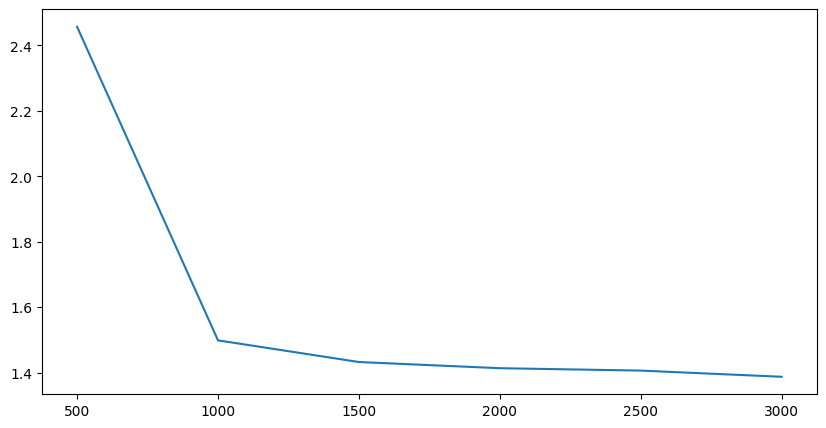

In [18]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.steps, loss_logger.train_losses, label='Training Loss')
plt.plot(loss_logger.steps, loss_logger.eval_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import math

eval_results=trainer.evaluate() 
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 3.75


In [20]:
trainer.model.save_pretrained(save_path)

NameError: name 'save_path' is not defined

In [21]:
#### peft_model.config.use_cache=True
context=tokenizer(["المملكة العربية السعودية"], return_tensors="pt")
output=model.generate(**context)

tokenizer.decode(output[0], skip_special_tokens=True)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'Saudi Arabia.'

In [24]:
tokenizer.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(os.getenv("WANDB_NAME"))

HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-66ab02e0-6155a20068a97ace13c4caa7;e1ee83e7-fba6-46c4-9c92-fd8033baaec1)

Invalid username or password.